# Time rescaling theorem and Kolmogorov-Smirnov test

## Game plan

1. specify "interesting", time-varying rate function
- generate spikes with a constant firing rate
- look at ISIs and verify that the ISIs follow the expected [non-physical] exponential distribution
- generate spikes having the time-varying rate function from above using method 2 from the notes (see [here](https://github.com/ckemere/CourseNotes/blob/master/NeuralSignalProcessing/PoissonNotes/PoissProcRev.pdf)).
- estimate firing rate using a Guassian kernel
- consider multiple trials for better [more robust] results
- estimate firing rate across trials

**Now we have data that looks like it has a sinusoidal firing rate. We want to test this hypothesis. Enter time rescaling and K-S test!**

1. look at distribution of spike times (sinusoidal shape should be apparent)
1. re-scale spike times using the assumed sinusoidal rate function
1. look at distribution of re-scaled spike times, which should appear uniform IF the assumed model was good
1. look at ISIs of re-scaled spike times
1. sanity check: generate uniform rate spikes and compare their ISIs to the re-scaled ISIs from above
1. how do we report our assertion that the model seems to be good? K-S test
1. perform K-S test manually, and with scipy
1. if model was good, then we will fail to reject the null hypothesis that the distributions are equivalent (WE DO NOT ASSERT THAT THE NULL HYPOTHESIS IS TRUE!)

**Q. Which distributions do we test in the K-S test?**
1. the CDF of the sinudoisal rate function and the ECDF of the ISIs of the data?
1. the CDF of an exponential distribution and the ECDF of the ISIs of the re-scaled spike times? <-- correct answer
1. the CDF of the sinusoidal rate function and the ECDF of the re-scaled ISIs?
1. the CDF of an exponential distribution and an Erlang distribution with rate equal to the mean firing rate (the re-scaled spikes have constant rate equal to this mean)?
1. the CDF of an exponential distribution and the ECDF of exponentially distributed RVs with the same size (number) as the un-scaled spikes?

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Part I: data synthesis

## 1. Specify "interesting", time-varying rate function

In [2]:
def rate(t, mu=15, c=12, f=0.75):
    return mu + c*np.sin(2*np.pi*f*t)

freq = 0.75  # firing rate frequency (of sinusoid)
mu = 15    # mean firing rate
c = 12     # firing rate amplitude

true_rate = lambda t: rate(t, mu=mu, c=c, f=freq)

**Remark:** lambda functions (anonymous functions) are cool; use them!

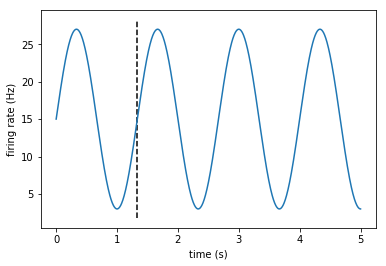

In [3]:
T0 = 0
T = 5
n_points = 1000

t = np.linspace(T0, T0 + T, n_points)

plt.plot(t, true_rate(t))
plt.xlabel('time (s)')
plt.ylabel('firing rate (Hz)')
plt.vlines(T0+1/freq, *plt.gca().get_ylim(), linestyle='--');

## 2. Generate spikes with a constant firing rate using method 2 from the notes (see [here](https://github.com/ckemere/CourseNotes/blob/master/NeuralSignalProcessing/PoissonNotes/PoissProcRev.pdf))

we generated 148 spikes (160 expected).


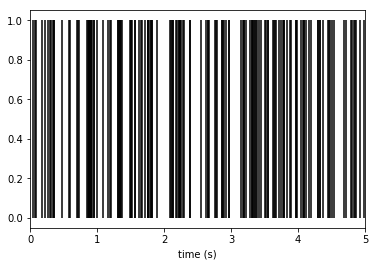

In [4]:
rate_max = mu + c + 5

# using method 2, from notes
n_spikes = np.random.poisson(rate_max * T)
spike_times = T0 + np.random.uniform(0, T, n_spikes)
spike_times.sort()

print('we generated {} spikes ({} expected).'.format(len(spike_times), rate_max*T))
plt.vlines(spike_times, 0, 1); plt.xlabel('time (s)'); plt.xlim(T0, T0+T);

**Remark:** the above homogeneous Poisson process does not respect refractory periods.

## 3. Look at ISIs and verify that the ISIs follow the expected [non-physical] exponential distribution

In [5]:
def exponential_func(t, lam):
    return lam*np.exp(-lam*t)

In [6]:
isi = np.diff(spike_times)

tt = np.linspace(0., 2, 1000)
yy = exponential_func(tt, rate_max)

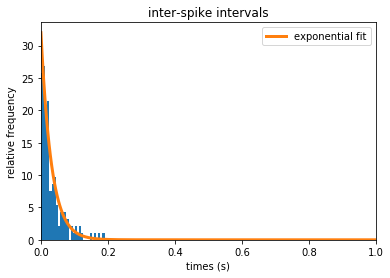

In [7]:
plt.hist(isi, bins=30, normed=True);
plt.plot(tt,yy, label='exponential fit', lw=3)
plt.xlim(0,1)
plt.title('inter-spike intervals')
plt.xlabel('times (s)')
plt.ylabel('relative frequency')
plt.legend()

## 4. Generate spikes having the time-varying rate function from above using method 1 from the notes (see [here](https://github.com/ckemere/CourseNotes/blob/master/NeuralSignalProcessing/PoissonNotes/PoissProcRev.pdf))

In [8]:
n_spikes = len(spike_times)
U = np.random.uniform(0, 1, n_spikes)
accept = U <= rate(spike_times)/rate_max
spikes = spike_times[accept]

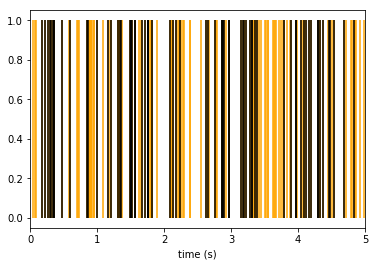

In [9]:
plt.vlines(spike_times, 0, 1, color='orange'); plt.xlabel('time (s)'); plt.xlim(T0, T0+T);
plt.vlines(spikes, 0, 1); plt.xlabel('time (s)'); plt.xlim(T0, T0+T);

## 5. Estimate firing rate using a Guassian kernel

In [10]:
n_spikes = len(spikes)
mean_firing_rate = n_spikes/T
print(mean_firing_rate)

14.0


 - bin time into small (10 ms?) bins, and count how many spikes fall within each bin
 - convolve with a Guassian kernel

In [11]:
dt = 0.010 # 10 ms
n_bins = T/dt
bins = np.linspace(T0,T0+T, n_bins+1)
tt = (bins[:-1] + bins[1:]) / 2 # (L+R)/2

binned, _ = np.histogram(spikes, bins=bins)
binned = binned.astype(float)

In [12]:
binned.max()

2.0

In [13]:
import scipy.ndimage.filters

bw=4
sigma = 0.1 # 100 ms
sigma = sigma/dt
rate_est = scipy.ndimage.filters.gaussian_filter(binned, sigma=sigma, truncate=bw)/dt

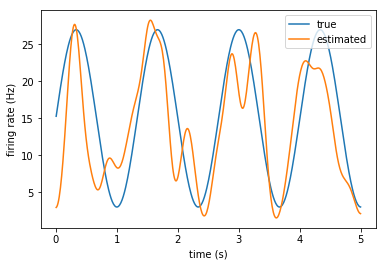

In [14]:
plt.plot(tt, true_rate(tt), label='true')
plt.plot(tt, rate_est, label='estimated')
plt.xlabel('time (s)')
plt.ylabel('firing rate (Hz)')
plt.legend();

**Remarks:** our estimate is not particularly good. Why is that? What can we do about it?

## 6. Consider multiple trials for better [more robust] results

In [15]:
def gen_data(rate_func, T0=0, T=5, n_points=100, n_trials=15):
    
    spike_data = []
    #Q. what should lambda max be??
    rate_max = 10000
    
    for trial in range(n_trials):
        # using method 2, from notes
        n_spikes = np.random.poisson(rate_max * T)
        spike_times = T0 + np.random.uniform(0, T, n_spikes)
        spike_times.sort()
        
        n_spikes = len(spike_times)
        U = np.random.uniform(0,1,n_spikes)
        accept = U <= rate_func(spike_times)/rate_max
        spikes = spike_times[accept]

        spike_data.append(spikes)
        
    return spike_data

In [16]:
from scipy.optimize import minimize

g = lambda t: -rate(t, mu=15, c=12, f=0.75)
res = minimize(g, x0=0) # what if x0=1?

print('func max seems to be :', -res.fun)

func max seems to be : 26.999999999999993


Text(0,0.5,'trial')

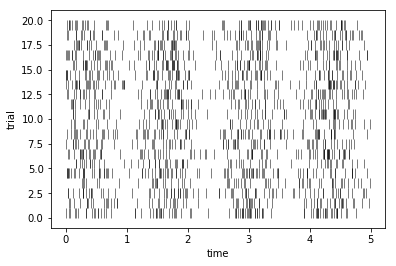

In [17]:
def plot_raster(arr):
    for trial, spikes in enumerate(arr):
        plt.vlines(x=spikes, ymin=trial, ymax=trial+1, lw=0.5)
        
spikes = gen_data(true_rate, n_trials=20)

plot_raster(spikes); plt.xlabel('time'); plt.ylabel('trial')

Text(0,0.5,'trial')

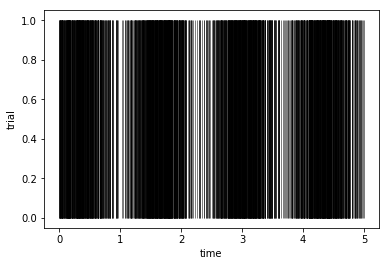

In [18]:
all_spikes = np.hstack(spikes)
all_spikes.sort()

plot_raster([all_spikes]); plt.xlabel('time'); plt.ylabel('trial')

## 7. Estimate firing rate across trials

In [19]:
def get_firing_rate(spikes, T0, T, dt=0.001, sigma=0.05):
    
    import scipy.ndimage.filters
    
    all_spikes = np.hstack(spikes)
    all_spikes.sort()

    n_trials = len(spikes)
    
    n_bins = T/dt
    bins = np.linspace(T0,T0+T, n_bins+1)
    tt = (bins[:-1] + bins[1:]) / 2

    binned, _ = np.histogram(all_spikes, bins=bins)
    binned = binned.astype(float)

    bw=4
    sigma = sigma/dt
    firing_rate = scipy.ndimage.filters.gaussian_filter(binned, sigma=sigma, truncate=bw)/dt/n_trials
    
    return firing_rate, tt

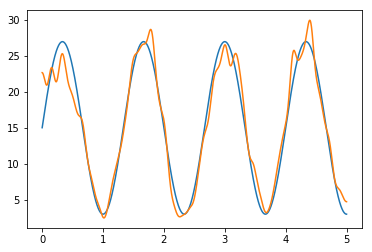

In [20]:
firing_rate, tt = get_firing_rate(spikes, T0=0, T=5)

plt.plot(tt, true_rate(tt), label='true rate')
plt.plot(tt, firing_rate, label='estimated rate')

Let's look at a few more examples:

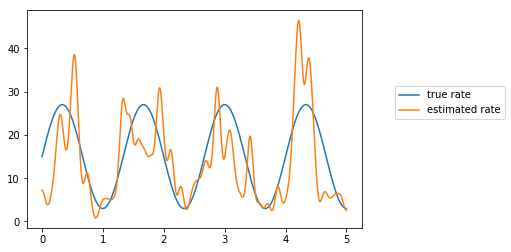

In [21]:
spikes = gen_data(true_rate, n_trials=2)

firing_rate, tt = get_firing_rate(spikes, T0=0, T=5 )

plt.plot(tt, true_rate(tt), label='true rate')
plt.plot(tt, firing_rate, label='estimated rate')
plt.legend(loc=(1.1,0.5))

# Part II: model validation

Q. how should we apply the time rescaling theorem with multiple trials? firing rate scales linearly w number of trials...

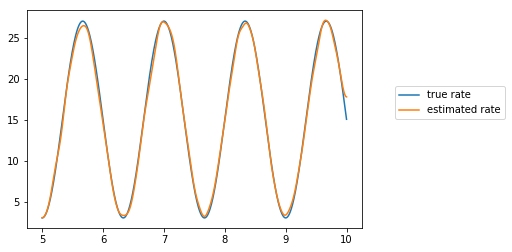

In [22]:
n_trials = 500 # retry with 2
mu=15
T0=5
T=5
true_rate = lambda t: rate(t, mu=mu)
spikes = gen_data(true_rate, n_trials=n_trials, T0=T0, T=T)

firing_rate, tt = get_firing_rate(spikes, T0=T0, T=T )

plt.plot(tt, true_rate(tt), label='true rate')
plt.plot(tt, firing_rate, label='estimated rate')
plt.legend(loc=(1.1,0.5))

## II.1) Look at distribution of spike times (sinusoidal shape should be apparent)

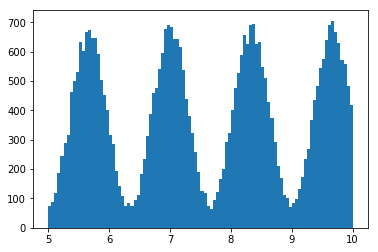

In [23]:
all_spikes = np.hstack(spikes)
all_spikes.sort()

plt.hist(all_spikes, bins=100);

## II.2) Re-scale spike times using the assumed sinusoidal rate function

In [24]:
def fun_integrate(fun, a, b, n_points=1000):
    
    from scipy.interpolate import interp1d
    
    tt = np.linspace(a, b, n_points)
    # rescale so that range is between 0 and 1
    dt = (tt[1]-tt[0])
    I = interp1d(tt, np.cumsum(fun(tt)*dt))
    
    return I, tt

Text(0,0.5,'re-scaled time')

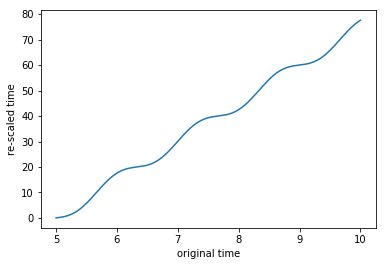

In [25]:
I, tt = fun_integrate(true_rate, T0, T0+T)

plt.plot(tt, I(tt))
plt.xlabel('original time')
plt.ylabel('re-scaled time')

In [26]:
rescaled = I(all_spikes)

## II.3) Look at distribution of re-scaled spike times, which should appear uniform IF the assumed model was good

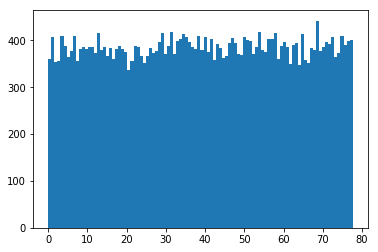

In [27]:
plt.hist(rescaled, bins=100);

## II.4) look at ISIs of re-scaled spike times

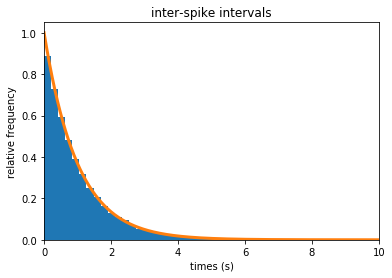

In [28]:
isi = np.diff(rescaled*n_trials) # rescaled times
tt = np.linspace(0., 10, 1000)
yy = exponential_func(tt, 1) # exponential with unit rate

plt.hist(isi, bins=50, normed=True);
plt.plot(tt,yy, lw=3)

plt.xlim(0, 10)
plt.title('inter-spike intervals')
plt.xlabel('times (s)')
plt.ylabel('relative frequency');

## II.5) Sanity check: generate uniform rate spikes and compare their ISIs to the re-scaled ISIs from above

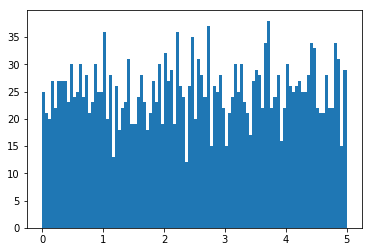

In [29]:
rate_func2 = lambda t: rate(t, mu=n_trials, c=0, f=0.75) # notice that lambda max now needs to be bigger than before!!!
spikes2 = gen_data(rate_func2, n_trials=1)[0]

plt.hist(spikes2, bins=100);

Text(0,0.5,'relative frequency')

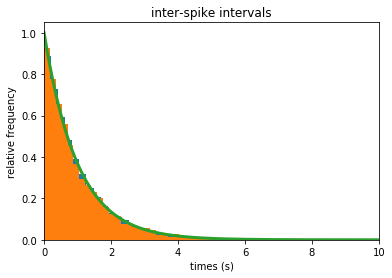

In [31]:
isi = np.diff(rescaled*n_trials) # rescaled times
isi2 = np.diff(spikes2*n_trials)      # uniform rate synthetic spikes

tt = np.linspace(0., 10, 1000)
yy = exponential_func(tt, 1) # exponential with unit rate

plt.hist(isi, bins=50, normed=True);
plt.hist(isi2, bins=50, normed=True);
plt.plot(tt,yy, label='exponential fit', lw=3)

plt.xlim(0, 10)
plt.title('inter-spike intervals')
plt.xlabel('times (s)')
plt.ylabel('relative frequency')
# plt.legend()

## II.6) How do we report our assertion that the model seems to be good? K-S test

### Now we compare CDF of model (exp(1), NOT true_rate) against empirical CDF of re-scaled data

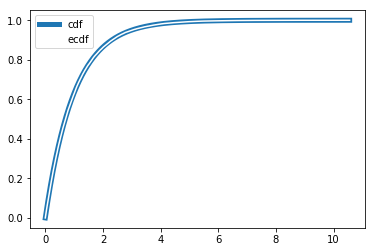

In [32]:
a = np.diff(rescaled)*n_trials
x = np.sort(a)
ecdf = np.arange(len(x))/float(len(x))
cdf = 1 - np.exp(-x)
plt.plot(x, cdf, label='cdf', lw=5)
plt.plot(x, ecdf, label='ecdf', c='w')
plt.legend()

## II.7) Perform K-S test manually, and with scipy

In [33]:
ks_stat = np.max(np.abs(cdf-ecdf))
print(ks_stat)

from scipy.stats import kstest

cdf_ = lambda t: 1 - np.exp(-t)
print(kstest(rvs=x, cdf=cdf_))

0.00448361993025
KstestResult(statistic=0.0044836199302472068, pvalue=0.42147005735715115)


**Remark:** Why are the two statistics similar, but not equal?

## pvalue > 0.05 ==> fail to reject null hypothesis (that distributions are equal)
## hence we have evidence to suggest that the distirutions might be equal ==> sinusoidal rate func may be a good model
## HOWEVER! Failing to reject the null hypothesis is NOT the same as asserting that the null hypothesis is true.

**Remark:** Also, this test works for varying N, which is kind of the point... Kolmogorov's innovation was to characterize the _rate_ at which the empirical distribution would converge to the true distribution as N increases.